In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/kaggle_histo/train/'
test_dir = "data/kaggle_histo/test/"

extracted_features_dir = "extracted_features/"
model_name = "kaggle_densenet"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/kaggle_histo/train/ 0
data/kaggle_histo/train/cancer 256400
data/kaggle_histo/train/normal 375900
******************************
data/kaggle_histo/test/ 0
data/kaggle_histo/test/cancer 6368
data/kaggle_histo/test/normal 9376


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 474225 images belonging to 2 classes.
Found 158075 images belonging to 2 classes.
Found 15744 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 474225
nb_validation_samples: 158075

predict_size_train: 14820
predict_size_validation: 4940
nb_test_samples: 15744
predict_size_test: 492

 num_classes: 2


In [9]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))


reset_keras_tf_session()

In [10]:
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile

input_tensor = Input(shape = input_shape)  
model = DenseNet201(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [11]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 zero_padding2d_1
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_2
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_block

695 conv5_block31_1_relu
696 conv5_block31_2_conv
697 conv5_block31_concat
698 conv5_block32_0_bn
699 conv5_block32_0_relu
700 conv5_block32_1_conv
701 conv5_block32_1_bn
702 conv5_block32_1_relu
703 conv5_block32_2_conv
704 conv5_block32_concat
705 bn
706 relu
707 avg_pool


In [12]:
c1 = model.layers[9].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[55].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[143].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[483].output
c4 = GlobalAveragePooling2D()(c4)

con = concatenate([c1, c2, c3, c4])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
bottleneck_final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

__________________________________________________________________________________________________
conv4_block17_concat (Concatena (None, 14, 14, 800)  0           conv4_block16_concat[0][0]       
                                                                 conv4_block17_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block18_0_bn (BatchNormal (None, 14, 14, 800)  3200        conv4_block17_concat[0][0]       
__________________________________________________________________________________________________
conv4_block18_0_relu (Activatio (None, 14, 14, 800)  0           conv4_block18_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block18_1_conv (Conv2D)   (None, 14, 14, 128)  102400      conv4_block18_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_bloc

conv4_block45_0_bn (BatchNormal (None, 14, 14, 1664) 6656        conv4_block44_concat[0][0]       
__________________________________________________________________________________________________
conv4_block45_0_relu (Activatio (None, 14, 14, 1664) 0           conv4_block45_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block45_1_conv (Conv2D)   (None, 14, 14, 128)  212992      conv4_block45_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block45_1_bn (BatchNormal (None, 14, 14, 128)  512         conv4_block45_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block45_1_relu (Activatio (None, 14, 14, 128)  0           conv4_block45_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_bloc

In [14]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [15]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [16]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 474225 samples, validate on 158075 samples
Epoch 1/1000
 - 63s - loss: 0.4253 - acc: 0.8070 - val_loss: 0.3638 - val_acc: 0.8412
Epoch 2/1000
 - 60s - loss: 0.3593 - acc: 0.8432 - val_loss: 0.3484 - val_acc: 0.8476
Epoch 3/1000
 - 60s - loss: 0.3443 - acc: 0.8500 - val_loss: 0.3326 - val_acc: 0.8545
Epoch 4/1000
 - 60s - loss: 0.3343 - acc: 0.8544 - val_loss: 0.3237 - val_acc: 0.8591
Epoch 5/1000
 - 60s - loss: 0.3269 - acc: 0.8579 - val_loss: 0.3168 - val_acc: 0.8624
Epoch 6/1000
 - 60s - loss: 0.3208 - acc: 0.8613 - val_loss: 0.3105 - val_acc: 0.8656
Epoch 7/1000
 - 60s - loss: 0.3156 - acc: 0.8643 - val_loss: 0.3086 - val_acc: 0.8671
Epoch 8/1000
 - 60s - loss: 0.3110 - acc: 0.8666 - val_loss: 0.3051 - val_acc: 0.8690
Epoch 9/1000
 - 60s - loss: 0.3070 - acc: 0.8689 - val_loss: 0.2956 - val_acc: 0.8734
Epoch 10/1000
 - 60s - loss: 0.3032 - acc: 0.8710 - val_loss: 0.2942 - val_acc: 0.8735
Epoch 11/1000
 - 60s - loss: 0.2996 - acc: 0.8729 - val_loss: 0.2880 - val_acc: 0.8785


Epoch 95/1000
 - 60s - loss: 0.2567 - acc: 0.9006 - val_loss: 0.2349 - val_acc: 0.9093
Epoch 96/1000
 - 60s - loss: 0.2562 - acc: 0.9005 - val_loss: 0.2364 - val_acc: 0.9079
Epoch 97/1000
 - 60s - loss: 0.2565 - acc: 0.9004 - val_loss: 0.2355 - val_acc: 0.9092
Epoch 98/1000
 - 60s - loss: 0.2559 - acc: 0.9010 - val_loss: 0.2426 - val_acc: 0.9048
Epoch 99/1000
 - 60s - loss: 0.2569 - acc: 0.9005 - val_loss: 0.2423 - val_acc: 0.9049
Epoch 100/1000
 - 60s - loss: 0.2560 - acc: 0.9014 - val_loss: 0.2409 - val_acc: 0.9072
Epoch 101/1000
 - 60s - loss: 0.2565 - acc: 0.9006 - val_loss: 0.2336 - val_acc: 0.9098
Epoch 102/1000
 - 60s - loss: 0.2564 - acc: 0.9013 - val_loss: 0.2409 - val_acc: 0.9066
Epoch 103/1000
 - 60s - loss: 0.2567 - acc: 0.9005 - val_loss: 0.2386 - val_acc: 0.9066
Epoch 104/1000
 - 60s - loss: 0.2564 - acc: 0.9010 - val_loss: 0.2340 - val_acc: 0.9094
Epoch 105/1000
 - 60s - loss: 0.2567 - acc: 0.9006 - val_loss: 0.2355 - val_acc: 0.9092
Epoch 106/1000
 - 60s - loss: 0.2573 

 - 60s - loss: 0.2626 - acc: 0.9032 - val_loss: 0.2350 - val_acc: 0.9127
Epoch 189/1000
 - 60s - loss: 0.2627 - acc: 0.9031 - val_loss: 0.2391 - val_acc: 0.9118
Epoch 190/1000
 - 60s - loss: 0.2622 - acc: 0.9032 - val_loss: 0.2338 - val_acc: 0.9144
Epoch 191/1000
 - 60s - loss: 0.2622 - acc: 0.9034 - val_loss: 0.2399 - val_acc: 0.9117
Epoch 192/1000
 - 60s - loss: 0.2627 - acc: 0.9034 - val_loss: 0.2424 - val_acc: 0.9105
Epoch 193/1000
 - 60s - loss: 0.2626 - acc: 0.9035 - val_loss: 0.2424 - val_acc: 0.9112
Epoch 194/1000
 - 60s - loss: 0.2625 - acc: 0.9032 - val_loss: 0.2413 - val_acc: 0.9119
Epoch 195/1000
 - 60s - loss: 0.2629 - acc: 0.9036 - val_loss: 0.2371 - val_acc: 0.9132
Epoch 196/1000
 - 60s - loss: 0.2625 - acc: 0.9033 - val_loss: 0.2375 - val_acc: 0.9141
Epoch 197/1000
 - 60s - loss: 0.2626 - acc: 0.9032 - val_loss: 0.2357 - val_acc: 0.9127
Epoch 198/1000
 - 60s - loss: 0.2635 - acc: 0.9036 - val_loss: 0.2462 - val_acc: 0.9089
Epoch 199/1000
 - 60s - loss: 0.2624 - acc: 0.9

Epoch 282/1000
 - 61s - loss: 0.2698 - acc: 0.9044 - val_loss: 0.2566 - val_acc: 0.9060
Epoch 283/1000
 - 63s - loss: 0.2692 - acc: 0.9044 - val_loss: 0.2426 - val_acc: 0.9151
Epoch 284/1000
 - 60s - loss: 0.2695 - acc: 0.9038 - val_loss: 0.2470 - val_acc: 0.9125
Epoch 285/1000
 - 60s - loss: 0.2700 - acc: 0.9042 - val_loss: 0.2503 - val_acc: 0.9107
Epoch 286/1000
 - 60s - loss: 0.2698 - acc: 0.9036 - val_loss: 0.2452 - val_acc: 0.9138
Epoch 287/1000
 - 60s - loss: 0.2695 - acc: 0.9040 - val_loss: 0.2445 - val_acc: 0.9133
Epoch 288/1000
 - 60s - loss: 0.2704 - acc: 0.9040 - val_loss: 0.2477 - val_acc: 0.9116
Epoch 289/1000
 - 60s - loss: 0.2702 - acc: 0.9041 - val_loss: 0.2398 - val_acc: 0.9132
Epoch 290/1000
 - 60s - loss: 0.2691 - acc: 0.9043 - val_loss: 0.2443 - val_acc: 0.9153
Epoch 291/1000
 - 60s - loss: 0.2697 - acc: 0.9040 - val_loss: 0.2410 - val_acc: 0.9146
Epoch 292/1000
 - 60s - loss: 0.2697 - acc: 0.9043 - val_loss: 0.2438 - val_acc: 0.9149
Epoch 293/1000
 - 60s - loss: 0.

 - 60s - loss: 0.2748 - acc: 0.9046 - val_loss: 0.2490 - val_acc: 0.9141
Epoch 376/1000
 - 60s - loss: 0.2746 - acc: 0.9048 - val_loss: 0.2470 - val_acc: 0.9139
Epoch 377/1000
 - 60s - loss: 0.2748 - acc: 0.9048 - val_loss: 0.2518 - val_acc: 0.9149
Epoch 378/1000
 - 60s - loss: 0.2743 - acc: 0.9049 - val_loss: 0.2488 - val_acc: 0.9144
Epoch 379/1000
 - 60s - loss: 0.2752 - acc: 0.9045 - val_loss: 0.2485 - val_acc: 0.9153
Epoch 380/1000
 - 60s - loss: 0.2755 - acc: 0.9049 - val_loss: 0.2499 - val_acc: 0.9146
Epoch 381/1000
 - 60s - loss: 0.2751 - acc: 0.9045 - val_loss: 0.2503 - val_acc: 0.9134
Epoch 382/1000
 - 60s - loss: 0.2741 - acc: 0.9051 - val_loss: 0.2495 - val_acc: 0.9148
Epoch 383/1000
 - 60s - loss: 0.2749 - acc: 0.9045 - val_loss: 0.2459 - val_acc: 0.9151
Epoch 384/1000
 - 60s - loss: 0.2754 - acc: 0.9045 - val_loss: 0.2499 - val_acc: 0.9135
Epoch 385/1000
 - 60s - loss: 0.2757 - acc: 0.9046 - val_loss: 0.2555 - val_acc: 0.9113
Epoch 386/1000
 - 60s - loss: 0.2744 - acc: 0.9

Epoch 469/1000
 - 60s - loss: 0.2793 - acc: 0.9049 - val_loss: 0.2548 - val_acc: 0.9160
Epoch 470/1000
 - 60s - loss: 0.2789 - acc: 0.9056 - val_loss: 0.2592 - val_acc: 0.9120
Epoch 471/1000
 - 60s - loss: 0.2799 - acc: 0.9047 - val_loss: 0.2597 - val_acc: 0.9122
Epoch 472/1000
 - 60s - loss: 0.2814 - acc: 0.9043 - val_loss: 0.2505 - val_acc: 0.9154
Epoch 473/1000
 - 60s - loss: 0.2794 - acc: 0.9048 - val_loss: 0.2527 - val_acc: 0.9142
Epoch 474/1000
 - 60s - loss: 0.2802 - acc: 0.9046 - val_loss: 0.2617 - val_acc: 0.9125
Epoch 475/1000
 - 60s - loss: 0.2792 - acc: 0.9049 - val_loss: 0.2506 - val_acc: 0.9143
Epoch 476/1000
 - 60s - loss: 0.2800 - acc: 0.9045 - val_loss: 0.2577 - val_acc: 0.9129
Epoch 477/1000
 - 60s - loss: 0.2810 - acc: 0.9043 - val_loss: 0.2554 - val_acc: 0.9147
Epoch 478/1000
 - 60s - loss: 0.2804 - acc: 0.9044 - val_loss: 0.2492 - val_acc: 0.9159
Epoch 479/1000
 - 60s - loss: 0.2812 - acc: 0.9043 - val_loss: 0.2523 - val_acc: 0.9148
Epoch 480/1000
 - 60s - loss: 0.

 - 60s - loss: 0.2843 - acc: 0.9045 - val_loss: 0.2541 - val_acc: 0.9146
Epoch 563/1000
 - 60s - loss: 0.2841 - acc: 0.9046 - val_loss: 0.2590 - val_acc: 0.9118
Epoch 564/1000
 - 60s - loss: 0.2831 - acc: 0.9047 - val_loss: 0.2577 - val_acc: 0.9150
Epoch 565/1000
 - 60s - loss: 0.2835 - acc: 0.9042 - val_loss: 0.2590 - val_acc: 0.9148
Epoch 566/1000
 - 60s - loss: 0.2848 - acc: 0.9048 - val_loss: 0.2603 - val_acc: 0.9147
Epoch 567/1000
 - 60s - loss: 0.2831 - acc: 0.9055 - val_loss: 0.2560 - val_acc: 0.9149
Epoch 568/1000
 - 60s - loss: 0.2837 - acc: 0.9051 - val_loss: 0.2598 - val_acc: 0.9134
Epoch 569/1000
 - 60s - loss: 0.2841 - acc: 0.9051 - val_loss: 0.2615 - val_acc: 0.9123
Epoch 570/1000
 - 60s - loss: 0.2842 - acc: 0.9047 - val_loss: 0.2580 - val_acc: 0.9153
Epoch 571/1000
 - 60s - loss: 0.2839 - acc: 0.9052 - val_loss: 0.2581 - val_acc: 0.9145
Epoch 572/1000
 - 60s - loss: 0.2845 - acc: 0.9049 - val_loss: 0.2525 - val_acc: 0.9149
Epoch 573/1000
 - 60s - loss: 0.2844 - acc: 0.9

Epoch 656/1000
 - 61s - loss: 0.2869 - acc: 0.9048 - val_loss: 0.2611 - val_acc: 0.9139
Epoch 657/1000
 - 60s - loss: 0.2875 - acc: 0.9053 - val_loss: 0.2578 - val_acc: 0.9147
Epoch 658/1000
 - 60s - loss: 0.2877 - acc: 0.9050 - val_loss: 0.2624 - val_acc: 0.9150
Epoch 659/1000
 - 60s - loss: 0.2870 - acc: 0.9052 - val_loss: 0.2585 - val_acc: 0.9168
Epoch 660/1000
 - 60s - loss: 0.2871 - acc: 0.9055 - val_loss: 0.2641 - val_acc: 0.9152
Epoch 661/1000
 - 60s - loss: 0.2874 - acc: 0.9052 - val_loss: 0.2588 - val_acc: 0.9162
Epoch 662/1000
 - 60s - loss: 0.2863 - acc: 0.9056 - val_loss: 0.2625 - val_acc: 0.9161
Epoch 663/1000
 - 60s - loss: 0.2876 - acc: 0.9053 - val_loss: 0.2637 - val_acc: 0.9143
Epoch 664/1000
 - 60s - loss: 0.2879 - acc: 0.9049 - val_loss: 0.2653 - val_acc: 0.9116
Epoch 665/1000
 - 60s - loss: 0.2883 - acc: 0.9050 - val_loss: 0.2652 - val_acc: 0.9147
Epoch 666/1000
 - 60s - loss: 0.2879 - acc: 0.9052 - val_loss: 0.2603 - val_acc: 0.9160
Epoch 667/1000
 - 60s - loss: 0.

 - 60s - loss: 0.2907 - acc: 0.9045 - val_loss: 0.2712 - val_acc: 0.9149
Epoch 750/1000
 - 60s - loss: 0.2899 - acc: 0.9054 - val_loss: 0.2637 - val_acc: 0.9161
Epoch 751/1000
 - 60s - loss: 0.2907 - acc: 0.9048 - val_loss: 0.2634 - val_acc: 0.9151
Epoch 752/1000
 - 60s - loss: 0.2901 - acc: 0.9052 - val_loss: 0.2674 - val_acc: 0.9141
Epoch 753/1000
 - 60s - loss: 0.2904 - acc: 0.9055 - val_loss: 0.2632 - val_acc: 0.9164
Epoch 754/1000
 - 60s - loss: 0.2912 - acc: 0.9048 - val_loss: 0.2626 - val_acc: 0.9167
Epoch 755/1000
 - 61s - loss: 0.2898 - acc: 0.9056 - val_loss: 0.2644 - val_acc: 0.9140
Epoch 756/1000
 - 60s - loss: 0.2910 - acc: 0.9047 - val_loss: 0.2636 - val_acc: 0.9164
Epoch 757/1000
 - 60s - loss: 0.2903 - acc: 0.9059 - val_loss: 0.2675 - val_acc: 0.9159
Epoch 758/1000
 - 60s - loss: 0.2918 - acc: 0.9050 - val_loss: 0.2608 - val_acc: 0.9162
Epoch 759/1000
 - 60s - loss: 0.2915 - acc: 0.9052 - val_loss: 0.2630 - val_acc: 0.9154
Epoch 760/1000
 - 60s - loss: 0.2909 - acc: 0.9

Epoch 843/1000
 - 60s - loss: 0.2926 - acc: 0.9052 - val_loss: 0.2668 - val_acc: 0.9166
Epoch 844/1000
 - 61s - loss: 0.2919 - acc: 0.9052 - val_loss: 0.2649 - val_acc: 0.9172
Epoch 845/1000
 - 60s - loss: 0.2928 - acc: 0.9052 - val_loss: 0.2650 - val_acc: 0.9159
Epoch 846/1000
 - 60s - loss: 0.2925 - acc: 0.9054 - val_loss: 0.2679 - val_acc: 0.9167
Epoch 847/1000
 - 60s - loss: 0.2935 - acc: 0.9050 - val_loss: 0.2644 - val_acc: 0.9129
Epoch 848/1000
 - 60s - loss: 0.2921 - acc: 0.9052 - val_loss: 0.2674 - val_acc: 0.9163
Epoch 849/1000
 - 60s - loss: 0.2940 - acc: 0.9047 - val_loss: 0.2646 - val_acc: 0.9139
Epoch 850/1000
 - 60s - loss: 0.2927 - acc: 0.9050 - val_loss: 0.2625 - val_acc: 0.9178
Epoch 851/1000
 - 60s - loss: 0.2934 - acc: 0.9047 - val_loss: 0.2674 - val_acc: 0.9137
Epoch 852/1000
 - 60s - loss: 0.2936 - acc: 0.9049 - val_loss: 0.2669 - val_acc: 0.9160
Epoch 853/1000
 - 60s - loss: 0.2933 - acc: 0.9051 - val_loss: 0.2719 - val_acc: 0.9159
Epoch 854/1000
 - 60s - loss: 0.

 - 60s - loss: 0.2955 - acc: 0.9053 - val_loss: 0.2682 - val_acc: 0.9172
Epoch 937/1000
 - 60s - loss: 0.2961 - acc: 0.9051 - val_loss: 0.2649 - val_acc: 0.9168
Epoch 938/1000
 - 60s - loss: 0.2943 - acc: 0.9056 - val_loss: 0.2690 - val_acc: 0.9164
Epoch 939/1000
 - 60s - loss: 0.2935 - acc: 0.9049 - val_loss: 0.2690 - val_acc: 0.9170
Epoch 940/1000
 - 60s - loss: 0.2940 - acc: 0.9050 - val_loss: 0.2768 - val_acc: 0.9132
Epoch 941/1000
 - 60s - loss: 0.2952 - acc: 0.9051 - val_loss: 0.2648 - val_acc: 0.9165
Epoch 942/1000
 - 61s - loss: 0.2951 - acc: 0.9048 - val_loss: 0.2681 - val_acc: 0.9159
Epoch 943/1000
 - 60s - loss: 0.2945 - acc: 0.9053 - val_loss: 0.2691 - val_acc: 0.9141
Epoch 944/1000
 - 61s - loss: 0.2949 - acc: 0.9054 - val_loss: 0.2655 - val_acc: 0.9159
Epoch 945/1000
 - 61s - loss: 0.2942 - acc: 0.9056 - val_loss: 0.2707 - val_acc: 0.9156
Epoch 946/1000
 - 61s - loss: 0.2957 - acc: 0.9057 - val_loss: 0.2730 - val_acc: 0.9134
Epoch 947/1000
 - 61s - loss: 0.2956 - acc: 0.9

In [18]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8784298780487805


Confusion Matrix
[[5823  545]
 [1369 8007]]


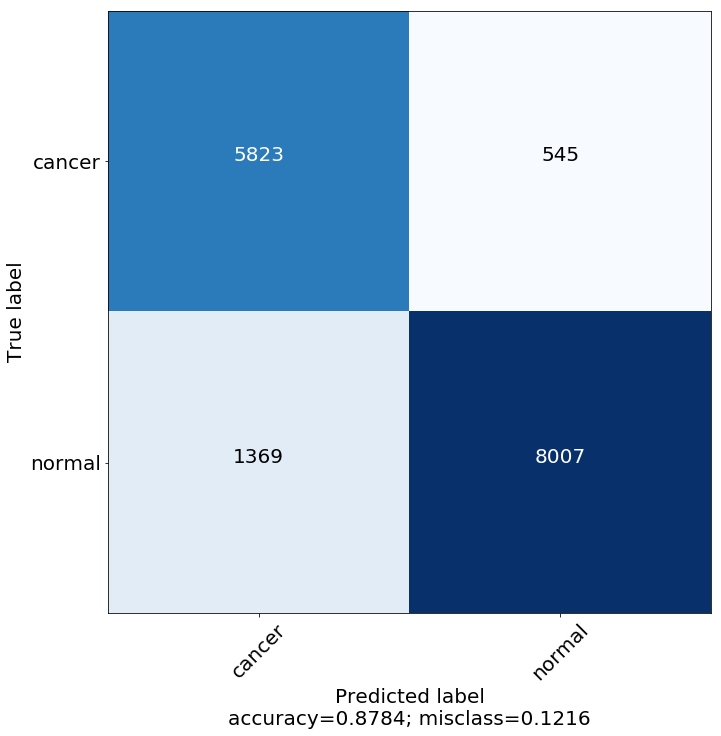

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[5823  545]
 [1369 8007]]
              precision    recall  f1-score   support

      normal       0.81      0.91      0.86      6368
      cancer       0.94      0.85      0.89      9376

   micro avg       0.88      0.88      0.88     15744
   macro avg       0.87      0.88      0.88     15744
weighted avg       0.89      0.88      0.88     15744



In [21]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  80.96496106785317
Specificity :  93.62722170252572


In [22]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.8729609138518943


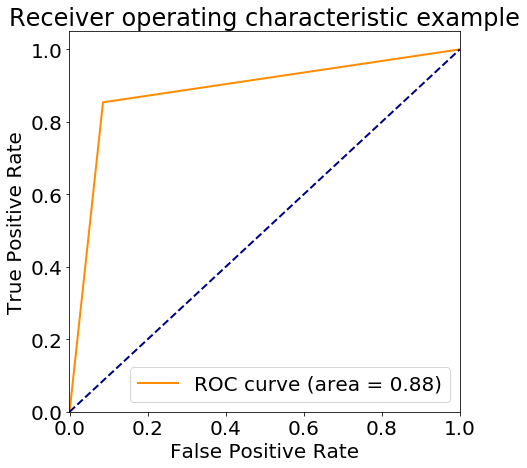

In [23]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [24]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

15744/15744 [==============================] - 1s 45us/step


In [25]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [26]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

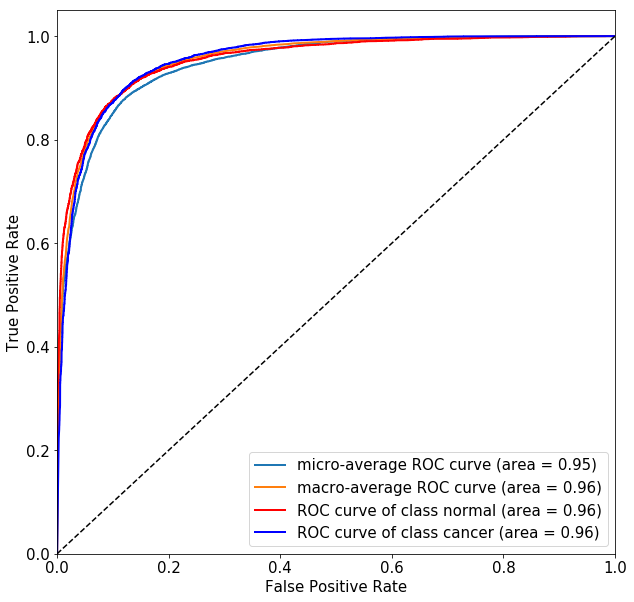

In [27]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [28]:
tn, fp, fn, tp = cm.ravel()

In [29]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.8784298780487805
Precision: 0.9362722170252572
Recall: 0.8539889078498294
tp: 8007
fp: 545
tn: 5823
fn: 1369


In [30]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.893239625167336


In [31]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.893239625167336


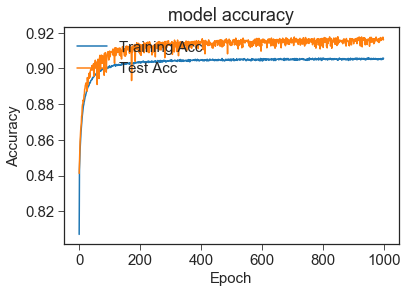

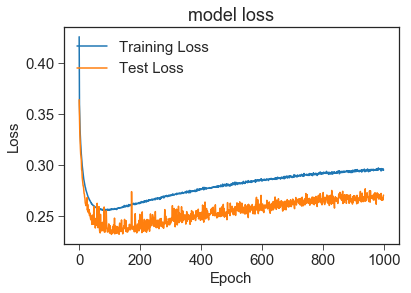

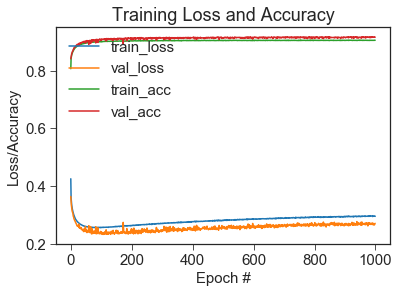

In [32]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")